# Nvidia Stock Price Prediction using LSTM

In [78]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM,Dense
from tensorflow.keras.optimizers import Adam

### Importing dataset

In [79]:
dataset = pd.read_csv('NVDA.csv')

In [80]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1,1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
2,1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
3,1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
4,1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


In [81]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6424.000000,6424.000000,6424.000000,6424.000000,6424.000000,6.424000e+03
mean,6.257007,6.371565,6.131920,6.256717,6.230362,6.060260e+08
std,16.294320,16.590700,15.939369,16.273800,16.276686,4.322545e+08
min,0.034896,0.035547,0.033333,0.034115,0.031291,1.968000e+07
25%,0.277500,0.286250,0.269500,0.276875,0.253958,3.456808e+08
50%,0.457375,0.465000,0.451375,0.457250,0.427725,5.069460e+08
75%,4.186187,4.240438,4.121688,4.180562,4.140063,7.361190e+08
max,139.800003,140.759995,132.419998,135.580002,135.580002,9.230856e+09


In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6424 entries, 0 to 6423
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6424 non-null   object 
 1   Open       6424 non-null   float64
 2   High       6424 non-null   float64
 3   Low        6424 non-null   float64
 4   Close      6424 non-null   float64
 5   Adj Close  6424 non-null   float64
 6   Volume     6424 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 351.4+ KB


## Predicting only 'Close' values

In [83]:
dataset = dataset[['Date','Close']]

In [84]:
dataset.head()

,Date,Close
0,1999-01-22,0.041016
1,1999-01-25,0.045313
2,1999-01-26,0.041797
3,1999-01-27,0.041667
4,1999-01-28,0.041536


### Converting string date into datetime datatype

In [85]:
def str_to_datetime(s):
    split = s.split('-')
    year,month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

In [86]:
dataset['Date'] = dataset['Date'].apply(str_to_datetime)
dataset['Date'].head()

0   1999-01-22
1   1999-01-25
2   1999-01-26
3   1999-01-27
4   1999-01-28
Name: Date, dtype: datetime64[ns]

### Making datetime as index of our dataframe

In [87]:
dataset.index = dataset.pop('Date')
dataset.head()

,Close
Date,
1999-01-22,0.041016
1999-01-25,0.045313
1999-01-26,0.041797
1999-01-27,0.041667
1999-01-28,0.041536


In [88]:
dataset.tail()

,Close
Date,
2024-07-29,111.589996
2024-07-30,103.730003
2024-07-31,117.019997
2024-08-01,109.209999
2024-08-02,107.269997


### Visulizing the dataset

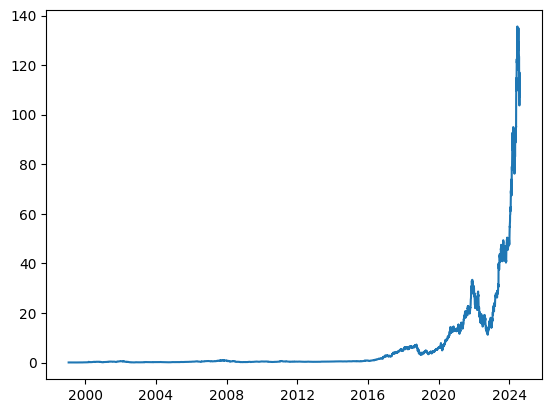

In [89]:
plt.plot(dataset.index,dataset['Close'])


### Making a windowed dataframe to train our LSTM model

In [90]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(dataset, 
                                '2024-01-04', 
                                '2024-08-02', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2024-01-04,49.521999,48.167999,47.569000,47.998001
1,2024-01-05,48.167999,47.569000,47.998001,49.097000
2,2024-01-08,47.569000,47.998001,49.097000,52.252998
3,2024-01-09,47.998001,49.097000,52.252998,53.139999
4,2024-01-10,49.097000,52.252998,53.139999,54.349998
...,...,...,...,...,...
141,2024-07-29,114.250000,112.279999,113.059998,111.589996
142,2024-07-30,112.279999,113.059998,111.589996,103.730003
143,2024-07-31,113.059998,111.589996,103.730003,117.019997
144,2024-08-01,111.589996,103.730003,117.019997,109.209999


In [91]:
def windowed_df_to_X_y(windowed_dataframe):
    numpy_df = windowed_dataframe.to_numpy()

    dates = numpy_df[:,0]
    middle_m = numpy_df[:,1:-1]
    X = middle_m.reshape((len(dates),middle_m.shape[1],1))
    y = numpy_df[:,-1]

    return dates, X.astype(np.float32), y.astype(np.float32)

dates,X,y = windowed_df_to_X_y(windowed_df)
dates.shape,X.shape,y.shape

((146,), (146, 3, 1), (146,))

### Splitting into training,validation and test sets

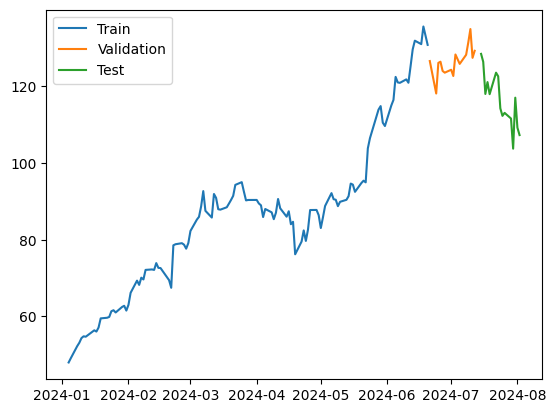

In [92]:
q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

dates_train,X_train,y_train = dates[:q_80],X[:q_80],y[:q_80]

dates_val,X_val,y_val = dates[q_80:q_90],X[q_80:q_90],y[q_80:q_90]
dates_test,X_test,y_test = dates[q_90:],X[q_90:],y[q_90:]

plt.plot(dates_train,y_train)
plt.plot(dates_val,y_val)
plt.plot(dates_test,y_test)

plt.legend(['Train','Validation','Test'])

In [93]:
model = Sequential()
model.add(Input((3,1)))
model.add(LSTM(64))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

### Model summary

In [94]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,065 (78.38 KB)

 Trainable params: 20,065 (78.38 KB)

 Non-trainable params: 0 (0.00 B)

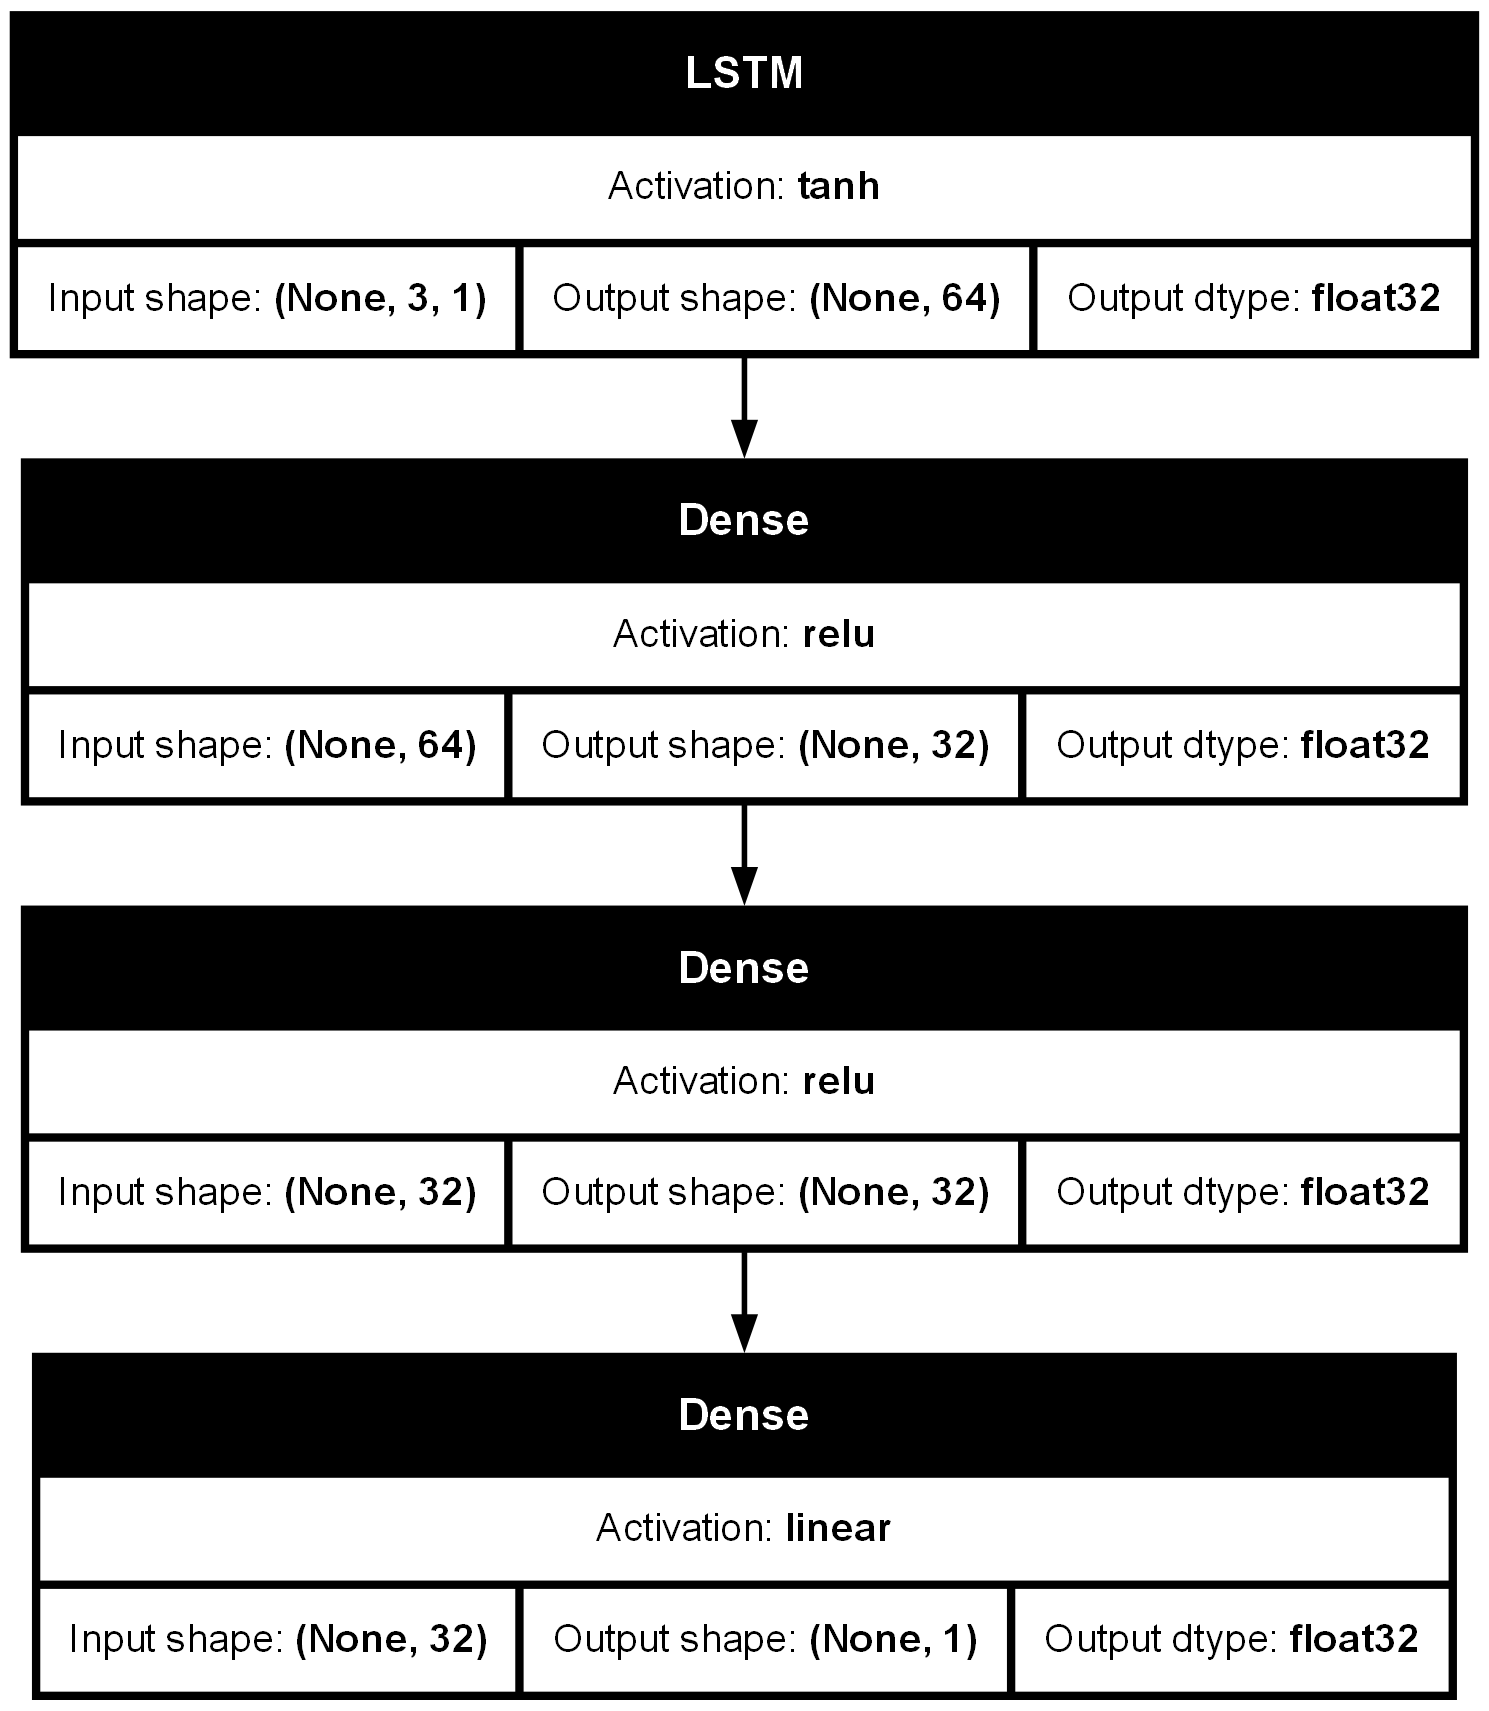

In [95]:
tensorflow.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [96]:
model.compile(loss='mse',
             optimizer=Adam(learning_rate=0.001),
             metrics=['mean_absolute_error'])

model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - loss: 7320.7256 - mean_absolute_error: 83.5526 - val_loss: 15795.1602 - val_mean_absolute_error: 125.6219
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7432.4966 - mean_absolute_error: 84.1981 - val_loss: 15705.7500 - val_mean_absolute_error: 125.2655
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7609.7520 - mean_absolute_error: 85.1634 - val_loss: 15604.3975 - val_mean_absolute_error: 124.8603
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7538.9204 - mean_absolute_error: 84.5101 - val_loss: 15487.6562 - val_mean_absolute_error: 124.3919
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7231.8032 - mean_absolute_error: 82.4849 - val_loss: 15357.3193 - val_mean_absolute_error: 123.8669
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7047.0034 - mean_absolute_error: 81.9469 - val_loss: 15206.0996 - val_mean_absolute_error: 123.2550
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step -

### Observing training,validation and test predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


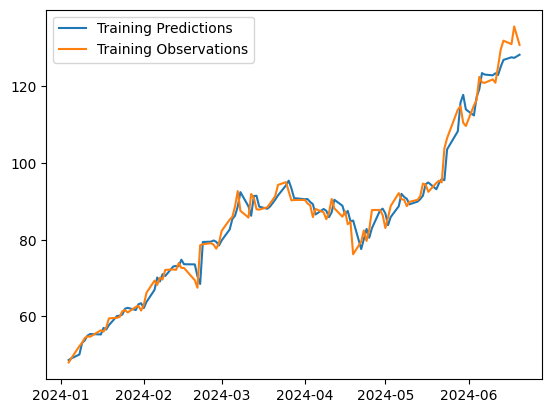

In [97]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


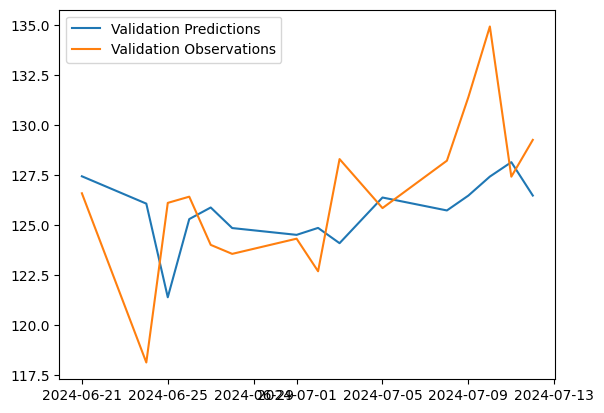

In [98]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


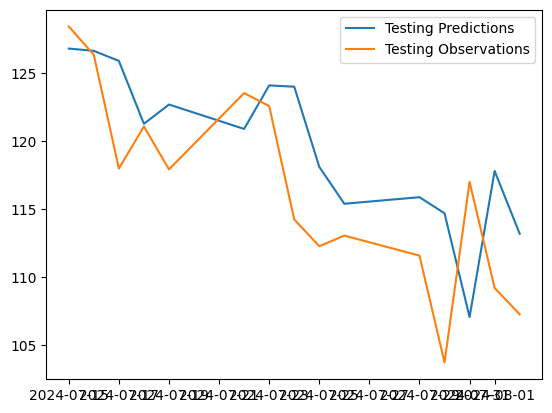

In [99]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

## Visulizing all three together

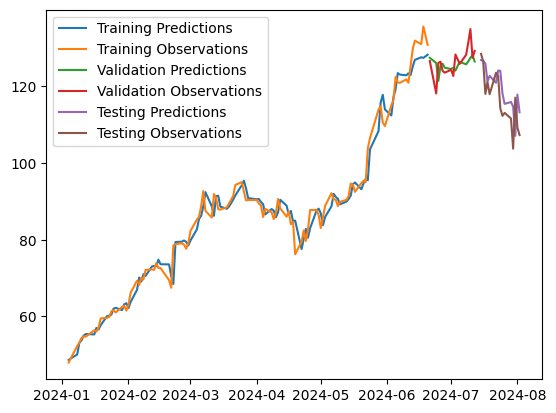

In [100]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])